# PyTorch - Model Interpretability 
## Lecture: Gradient-Based Methods: Gradient Class Activation Mapping

BSDS4 Deep Learning Elective
2022 DS Elective 4 <br>
University of Science and Technology of the Philippines <br>
Instructor: Romen Samuel Wabina, MSc <br>



### Let us first import the relevant libraries.

In [2]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms
from torch import optim
from torch import nn
import shap
from torchvision.utils import make_grid, save_image

from utils import visualize_cam, Normalize
from gradcam import GradCAM, GradCAMpp

import warnings 
warnings.filterwarnings('ignore')

c:\Users\Renan\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


## 1. Background of Gradient Class Activation Mapping (GradCAM)

Gradient-weighted Class Activation Mapping (Grad-CAM), uses the gradients of any target concept (say ‘dog’ in a classification network or a sequence of words in captioning network) flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept.

<center>
<img src="../images/gradcam.PNG" style="width: 840px;" />
</center>

We take an image as input and create a model that is cut off at the layer for which we want to create a Grad-CAM heat-map. We attach the fully-connected layers for prediction. We then run the input through the model, grab the layer output, and loss. Next, we find the gradient of the output of our desired model layer w.r.t. the model loss. From there, we take sections of the gradient which contribute to the prediction, reduce, resize, and rescale so that the heat-map can be overlaid with the original image.

The emphasized region (red) encapsulates regions of the cat but does not fit the cat with much precision. The region includes sections of the human’s shirt, the human’s hand, and the background. We know the model sees a cat, but we are not quite sure what it is about the cat that convinces the model that this is, in fact, a cat.

<center>
<img src = "../images/gradcam_sample.PNG" style="width: 840px;" />
</center>

### Why do we need Grad-CAM over other visualisation techniques?

- In the past, visualisation was done through Guided Backpropagation (Springenberg et al. (2014)) or Deconvolution (Zeiler and Furgus (2014)). These visualisation techniques tended to provide a high resolution but they could not localise the object(s) of interest.
- Grad-CAM is based on Class Activation Mapping (CAM) by Zhou et al. (2015) where CAM could identify discriminative regions for a particular class through CNNs.
- Grad-CAM complements/generalises CAM because CAM cannot visualise localised regions through models other than CNNs whilst Grad-CAM could visualise regions not only through CNNs but also from other models such as CNNs with fully-connected layers (e.g. VGG), CNNs used for structured outputs (e.g. captioning) and CNNs used in tasks with multi-modal inputs (VQA) or reinforcement learning.

<center>
<img src = "../images/backprop.PNG" style="width: 840px;" />
</center>

There are two steps involved in calculating Grad-CAM.
<center>
<img src = "../images/pooling.PNG" style="width: 340px;" />
</center>

<center>
<img src = "../images/pooling2.PNG" style="width: 340px;" />
</center>

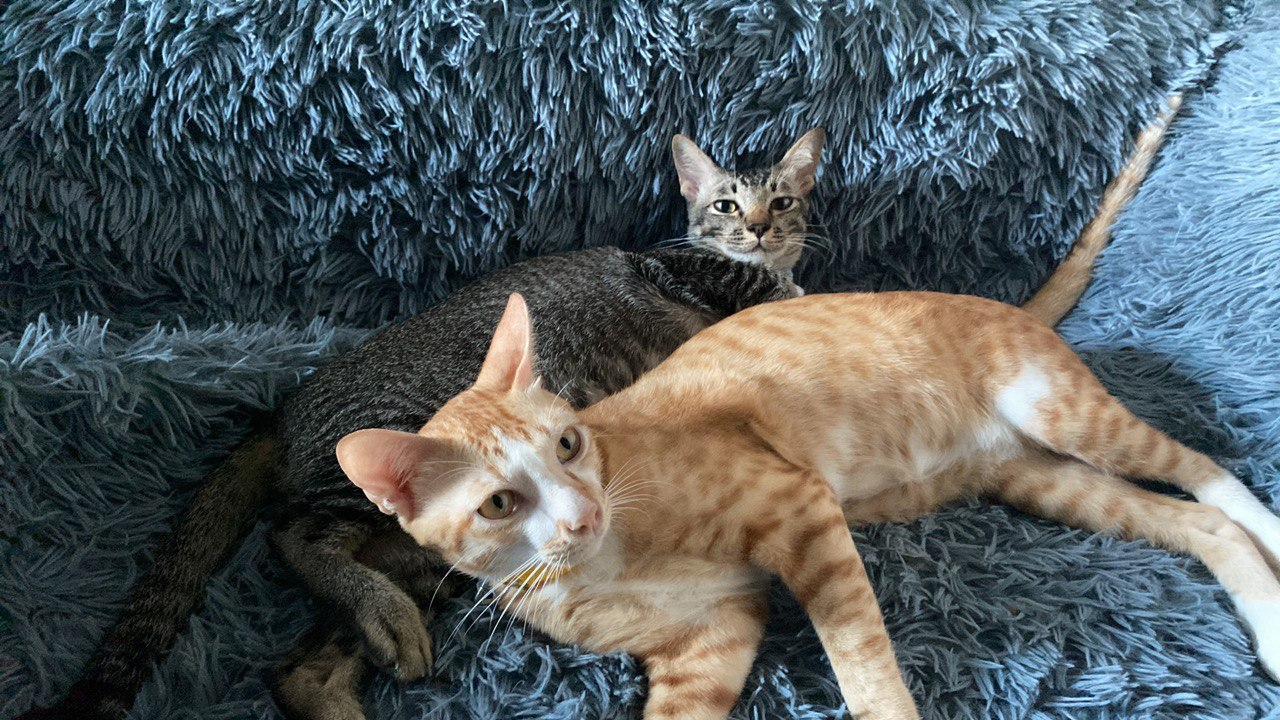

In [25]:
img_dir = '../images'
img_name = 'cats2.JPG'
img_path = os.path.join(img_dir, img_name)
pil_img = PIL.Image.open(img_path)
pil_img

In [9]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
torch_img = torch.from_numpy(np.asarray(pil_img)).permute(2, 0, 1).unsqueeze(0).float().div(255)
torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)
normed_torch_img = normalizer(torch_img)

Just use one of these models. Suppose we will use AlexNet

In [22]:
''' 
    vgg         = models.vgg16(pretrained=True).eval()
    resnet      = models.resnet101(pretrained=True).eval()
    densenet    = models.densenet161(pretrained=True).eval()
    squeezenet  = models.squeezenet1_1(pretrained=True).eval()
'''
densenet    = models.densenet161(pretrained=True).eval()

In [23]:
cnn_models = [densenet]
layer_name = ['features_11']
types = ['alexnet', 'vgg', 'resnet', 'densenet', 'squeezenet']

def train_model(cnn_models, layer_name, types, input_size = (224, 224)):
    cam_dict = dict()
    for model, layer, type in zip(cnn_models, layer_name, types):
        model_dict = dict(type = type, arch = model, layer_name = layer, input_size = input_size)
        model_grad = GradCAM(model_dict, True)
        model_capp = GradCAMpp(model_dict, True)
        cam_dict[type] = [model_grad, model_capp]
        return cam_dict

cam_dict = train_model(cnn_models, layer_name, types)
images = []
for gradcam, gradcam_pp in cam_dict.values():
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask, torch_img)
    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
    images.append(torch.stack([torch_img.squeeze().cpu(), heatmap, heatmap_pp, result, result_pp], 0))
images = make_grid(torch.cat(images, 0), nrow = 5)

saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])


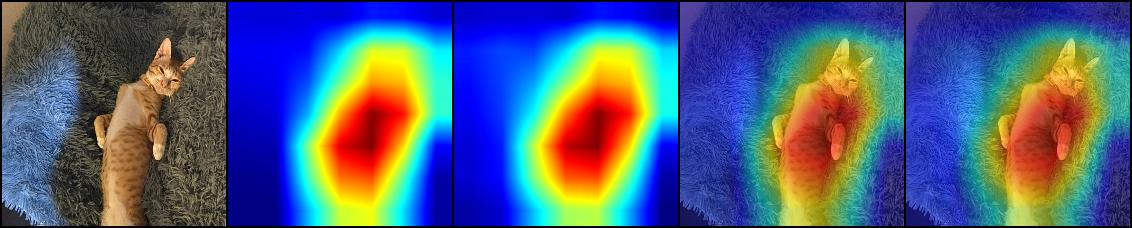

In [24]:
output_dir = '../outputs'
os.makedirs(output_dir, exist_ok = True)

output_name = img_name
output_path = os.path.join(output_dir, output_name)

save_image(images, output_path)
PIL.Image.open(output_path)